## 概要

本文讲解了pyorbbecsdk配置彩色相机参数的相关API。

## 通过上位机进行调参

在上位机界面，调整彩色相机的参数，查询彩色相机的各项参数。 
并且可以在上位机的右侧实时预览到不同参数下的图像效果。

![](./image/RGB彩色相机参数.png)

需要注意的是，在上位机界面调整的参数，掉电后并不会保存。通过SDK调用的时候，需要自己指定相机参数。

推荐的使用方法是，先通过上位机对相机参数进行调参，因为可以实时预览， 比较方便。 然后把配置参数记录下来，通过SDK调用的时候，再通过SDK提供的API接口配置为对应数值。 

> 注意事项: 在运行jupyter notebook测试脚本之前，记得将上位机关闭， 解除对相机设备的占用。

## 导入依赖

In [1]:
# 将pyorbbecsdk的动态链接库所在的文件夹，添加到Python Path
import sys
import os

# 导入阿凯写的Orbbec工具库, 确保orbbec_utils.py跟你目前所执行的脚本在同一级目录下
from orbbecsdk_utils import *
# 添加Python Path
add_path_pyorbbecsdk()

# 导入pyorbbecsdk
from pyorbbecsdk import *

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
import numpy as np
import cv2
import open3d as o3d
from matplotlib import pyplot as plt

import logging

# 获取logger实例
logger = logging.getLogger("OrbbecSDK Utils")
# 指定日志的最低输出级别
logger.setLevel(logging.ERROR)

## 初始化视频流

In [3]:
# 连接设备
ret, device = connect_device()
print(f"[INFO] 设备是否连接成功: {ret}")

# pipeline初始化
pipeline = init_pipeline(device)
# 清空缓冲区
empty_cache(pipeline)

# 获取pipeline的相机参数
camera_param = pipeline.get_camera_param()

[INFO] 设备是否连接成功: True
[05/25 00:02:03.419772][info][64240][Context.cpp:68] Context created with config: default config!
[05/25 00:02:03.419787][info][64240][Context.cpp:73] Work directory=/home/kyle/Project/奥比中光3D相机/Gemini2-软件资料-阿凯爱玩机器人/02.奥比中光-pyobbecsdk示例代码, SDK version=v1.10.5-20240511-7dc8be9
[05/25 00:02:03.419800][info][64240][LinuxPal.cpp:31] createObPal: create LinuxPal!
[05/25 00:02:03.491635][info][64240][LinuxPal.cpp:142] Create PollingDeviceWatcher!
[05/25 00:02:03.491658][info][64240][DeviceManager.cpp:15] Current found device(s): (1)
[05/25 00:02:03.491677][info][64240][DeviceManager.cpp:24] 	- Name: Orbbec Gemini 335, PID: 0x0800, SN/ID: CP1L44P00049, Connection: USB3.2
[05/25 00:02:03.959260][error][64240][HostProtocol.cpp:420] Set property value failed! propertyId:63, rc:{statusCode: 9, respErrorCode: 2, msg: }
[05/25 00:02:03.959540][error][64240][HostProtocol.cpp:420] Set property value failed! propertyId:63, rc:{statusCode: 9, respErrorCode: 2, msg: }


## 工具函数

In [4]:
def preview():
    '''预览彩图'''
    # 多采集几次, 清除缓存让配置生效
    for i in range(30):
        ret, color_img, depth_img = capture(pipeline)

    plt.imshow(color_img[:, :, ::-1])

In [5]:
def print_camera_param_info(device, prop_id):
    '''打印相机参数信息'''
    # 查询当前参数
    cur_value = device.get_int_property(prop_id)
    print(f"当前的参数配置为: {cur_value}")
    # 查询白平衡的取值范围
    value_range = device.get_int_property_range(prop_id)
    print(f"数值范围: 最小值 {value_range.min} | 最大值 {value_range.max}")

## 曝光

### 手动曝光值

In [6]:
# 手动曝光需要先将自动曝光开关关闭
device.set_bool_property(OBPropertyID.OB_PROP_COLOR_AUTO_EXPOSURE_BOOL, False)

In [7]:
# 查询当前的曝光值，与有效数值范围
print_camera_param_info(device, OBPropertyID.OB_PROP_COLOR_EXPOSURE_INT)

当前的参数配置为: 156
数值范围: 最小值 1 | 最大值 10000


In [8]:
# 手动配置曝光值，调整不同的曝光值，查看效果
device.set_int_property(OBPropertyID.OB_PROP_COLOR_EXPOSURE_INT, 30000)

### 自动曝光

In [9]:
# 查询彩色相机是否开启了自动曝光
device.get_bool_property(OBPropertyID.OB_PROP_COLOR_AUTO_EXPOSURE_BOOL)

False

In [10]:
# 配置是否开启自动曝光
auto_exposure = True
device.set_bool_property(OBPropertyID.OB_PROP_COLOR_AUTO_EXPOSURE_BOOL, auto_exposure)


## 白平衡

### 手动白平衡

In [11]:
# 切换为手动白平衡需要先关闭自动白平衡开关
device.set_bool_property(OBPropertyID.OB_PROP_COLOR_AUTO_WHITE_BALANCE_BOOL, False)

In [12]:
# 查询当前的白平衡，与有效数值范围
print_camera_param_info(device, OBPropertyID.OB_PROP_COLOR_WHITE_BALANCE_INT)

当前的参数配置为: 4600
数值范围: 最小值 2800 | 最大值 6500


In [13]:
# 设置白平衡
device.set_int_property(OBPropertyID.OB_PROP_COLOR_WHITE_BALANCE_INT, 5500)

### 自动白平衡开关

In [14]:
# 查询当前是否开启自动白平衡
device.get_bool_property(OBPropertyID.OB_PROP_COLOR_AUTO_WHITE_BALANCE_BOOL)

False

In [15]:
# 配置是否开启自动白平衡
auto_white_balance = True
device.set_bool_property(OBPropertyID.OB_PROP_COLOR_AUTO_WHITE_BALANCE_BOOL, auto_white_balance)

## 相机增益

In [16]:
# 查询当前的增益，与有效数值
print_camera_param_info(device, OBPropertyID.OB_PROP_COLOR_GAIN_INT)

当前的参数配置为: 16
数值范围: 最小值 0 | 最大值 128


In [17]:
# 设置相机增益
device.set_int_property(OBPropertyID.OB_PROP_COLOR_GAIN_INT, 100)

## 亮度

In [18]:
# 查询当前的亮度，与有效数值范围
print_camera_param_info(device, OBPropertyID.OB_PROP_COLOR_BRIGHTNESS_INT)

当前的参数配置为: 0
数值范围: 最小值 -64 | 最大值 64


In [19]:
# 设置相机亮度
device.set_int_property(OBPropertyID.OB_PROP_COLOR_BRIGHTNESS_INT, 52)

## 锐度

In [20]:
# 查询当前的锐度，与有效数值范围
print_camera_param_info(device, OBPropertyID.OB_PROP_COLOR_SHARPNESS_INT)

当前的参数配置为: 50
数值范围: 最小值 0 | 最大值 100


In [21]:
# 设置相机锐度
device.set_int_property(OBPropertyID.OB_PROP_COLOR_SHARPNESS_INT, 99)

## 饱和度

In [22]:
# 查询当前的饱和度，与有效数值范围
print_camera_param_info(device, OBPropertyID.OB_PROP_COLOR_SATURATION_INT)

当前的参数配置为: 64
数值范围: 最小值 0 | 最大值 100


In [23]:
# 设置相机饱和度
device.set_int_property(OBPropertyID.OB_PROP_COLOR_SATURATION_INT, 32)

## 对比度

In [24]:
# 查询当前的对比度，与有效数值范围
print_camera_param_info(device, OBPropertyID.OB_PROP_COLOR_CONTRAST_INT)

当前的参数配置为: 50
数值范围: 最小值 0 | 最大值 100


In [25]:
# 设置相机对比度
device.set_int_property(OBPropertyID.OB_PROP_COLOR_CONTRAST_INT, 32)

## 电力线路频率

In [26]:
# 查询当前的电力线路频率，与有效数值范围
print_camera_param_info(device, OBPropertyID.OB_PROP_COLOR_POWER_LINE_FREQUENCY_INT)

当前的参数配置为: 0
数值范围: 最小值 0 | 最大值 3


数值所代表的含义: 
* `0`: 关闭电力线路频率配置项
* `1`: `50HZ`
* `2`: `60HZ`

In [27]:
#  设置电力线路频率为50HZ
device.set_int_property(OBPropertyID.OB_PROP_COLOR_POWER_LINE_FREQUENCY_INT, 1)

## 图像预览

<IPython.core.display.Javascript object>


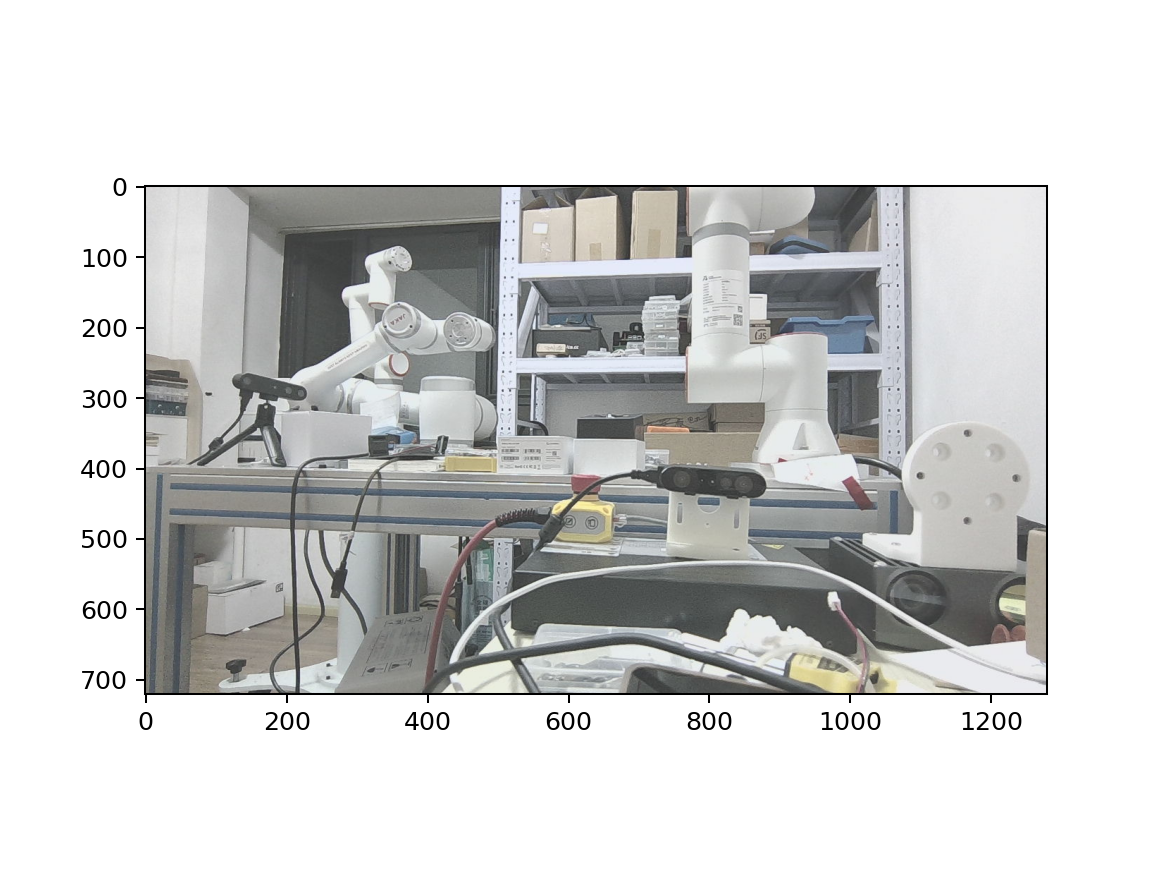

In [28]:
%matplotlib notebook
preview()